# MIMIC3 data preprocessing

Note: 
Part of this script is modified upon [MIMIC-Extract](https://github.com/MLforHealth/MIMIC_Extract) and [IP-Nets](https://github.com/mlds-lab/interp-net).

In [4]:
import pickle
import psycopg2 as py
import copy
import numpy as np
import torch
import os
import argparse
import pandas as pd
from datetime import datetime
import random
random.seed(49297)
from tqdm import tqdm, trange
import sys
import math
import tables

from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import matplotlib.dates as mdates
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as ss


ModuleNotFoundError: No module named 'tables'

In [34]:
conn = py.connect(
    "dbname = 'mimic3' user = 'user_name' host = 'localhost' password = 'password' options='-c search_path=dataset_name' ")

cur = conn.cursor()
# load icu stay
cur.execute("select hadm_id, icustay_id, intime, outtime, los from icustays")
icustays = cur.fetchall()

# load subject2hadm
cur.execute("select  subject_id, hadm_id from admissions")
subject2hadm = cur.fetchall()

In [35]:
# subj2adm dict
adm2subj_dict = {}

for subject_id, hadm_id in subject2hadm:
    if hadm_id not in adm2subj_dict:
        adm2subj_dict.update({hadm_id:subject_id})
    else:
        print("admid: ", str(hadm_id), "subject:", adm2subj_dict[hadm_id], subject_id)
        continue


print(len(subject2hadm))
print(len(adm2subj_dict))

58976
58976


In [36]:
# adm2icu dict
icu_dict = {}
los_dict = {}

for hadm_id, icustay_id, intime, outtime, los in icustays:
    if hadm_id not in icu_dict:
        icu_dict.update({hadm_id:{icustay_id:[intime, outtime]}})
        los_dict.update({str(hadm_id)+'_'+str(icustay_id) : los})
    elif icustay_id not in icu_dict[hadm_id]:
        icu_dict[hadm_id].update({icustay_id:[intime, outtime]})
        los_dict.update({str(hadm_id)+'_'+str(icustay_id): los})
    else:
        continue


len(icu_dict)
len(los_dict)

61532

In [37]:
adm2deathtime_dict = {}

# death time
cur.execute("""select hadm_id, deathtime from admissions """)
deathtimes = cur.fetchall()

print(len(deathtimes))

for hadm_id, deathtime in deathtimes:
    if hadm_id not in adm2deathtime_dict:
        adm2deathtime_dict.update({hadm_id:deathtime})

print(len(adm2deathtime_dict))

58976
58976


##  Load data

In [ ]:

min_time_period = 48

def load_adm_data(data_path):
    print('Loading files ...')
    adm_info = pickle.load(
            open(data_path, 'rb'))

    adm_id_needed = [record[0] for record in adm_info if record[2] >= min_time_period]


    print('Loading Done!')
    print(len(adm_info))
    return adm_info, adm_id_needed


adm_id_data_path = "path/to/adm_type_los_mortality.p"
adm_info, adm_id_needed = load_adm_data(adm_id_data_path)


In [39]:
# load biomarkers and events
def load_data(data_path, adm_info, adm_id_needed=None):
   
    print('Loading files ...')
    vitals = pickle.load(open(data_path, 'rb'))
    print('Loading Done!')
    
    adm_id = [record[0] for record in adm_info]
    
    if adm_id_needed is None:
        adm_id_needed = [record[0] for record in adm_info if record[2] >= min_time_period]


    vitals_dict = {}
    for i in range(len(adm_id)):
        vitals_dict[adm_id[i]] = vitals[i]

    vitals = [vitals_dict[x] for x in adm_id_needed]
    label = [rec[3] for x in adm_id_needed for rec in adm_info if x == rec[0]]
    
    return vitals, label


bio_path = "path/to/patient_records.p"
vitals, label = load_data(bio_path, adm_info, adm_id_needed=adm_id_needed)


Loading files ...
Loading Done!


## Feature selection

In [42]:
def select_features(data):
    for i in range(len(data)):
        for elem in data[i][7]:
            if elem[1] != None:
                # Fahrenheit->Celcius conversion
                tup = (elem[0], elem[1] * 1.8 + 32)
                data[i][6].append(tup)

        for elem in data[i][10]:
            data[i][9].append(elem)
        for elem in data[i][11]:
            data[i][9].append(elem)


        # removing duplicates and EtCO2
        del data[i][5]
        del data[i][6]
        del data[i][8]
        del data[i][8]

        for j in range(len(data[i][-1])):
            data[i][-1][j] = (data[i][-1][j][0], 1)

        for j in range(len(data[i][-2])):
            data[i][-2][j] = (data[i][-2][j][0], 1)

        del data[i][14]
        del data[i][18]
    
    print("pre-proc done")


select_features(vitals)
print(len(vitals[0]))

pre-proc done
23


## Dataset building

### Data shuffling (Optional)

In [44]:
tmp_data = list(zip(vitals, adm_id_needed, label))

random.shuffle(tmp_data)

rd_vitals = [i[0] for i in tmp_data]
rd_adm_id_needed = [i[1] for i in tmp_data]
rd_label = [i[2] for i in tmp_data]

vitals, adm_id_needed, label = rd_vitals, rd_adm_id_needed, rd_label

print("shuffling done")


shuffling done


### In-Hospital Mortality

In [ ]:
mor_adm_icu_id, mor_data, mor_label = adm_id_needed, vitals, label

### Clinical Intervention Prediction
- Predict intervention onset/offset within a 4h prediction window offset from the input window by a 6h gap window.
- Four possible outcomes: Onset / Stay On / Wean / Stay Off


In [5]:
# Please obtain this file from https://github.com/MLforHealth/MIMIC_Extract
DATAFILE = '/home/covpreduser/Blob/v-xiaosong/dataset/mimicextract/all_hourly_data.h5'

Y = pd.read_hdf(DATAFILE,'interventions')
Y = Y[['vent', 'vaso']]

In [7]:
len(Y)

2200954

In [47]:

CHUNK_KEY = {'ONSET': 0, 'CONTROL': 1, 'ON_INTERVENTION': 2, 'WEAN': 3}
def create_interv_pred(data, adm_ids, interv, sample_rate=6, observ_win=6, eps=1e-6, future_time_interval=4, gap_win=6, start=0, end=10000, need_sample=-1):
    adm_icu_id = []
    ip_data = []
    vent_labels = []
    vaso_labels = []

    # go through icu stays
    for i in trange(start, end):
        if need_sample != -1 and len(ip_data) > need_sample:
            break

        adm_data = data[i] # (23 * T_feature)
        if adm_ids[i] not in icu_dict:
            continue
        for icustay_id in icu_dict[adm_ids[i]]:
            icu_data = []
            if pd.isnull(los_dict[str(adm_ids[i])+'_'+str(icustay_id)]):
                continue

            adm_index = (adm2subj_dict[adm_ids[i]], adm_ids[i], icustay_id)
            

            los = 24.0 * los_dict[str(adm_ids[i])+'_'+str(icustay_id)]  # in hours

            deathtime = adm2deathtime_dict[adm_ids[i]]
            intime = icu_dict[adm_ids[i]][icustay_id][0]
            outtime = icu_dict[adm_ids[i]][icustay_id][1]

            if deathtime is None:
                lived_time = (outtime - intime).total_seconds() / 3600.0
            else:
                lived_time = (deathtime - intime).total_seconds() / 3600.0

            # select data within icu stay
            for k in range(len(adm_data)):
                kth_feature = []
                for t, value in adm_data[k]:
                    if intime < t < outtime:

                        kth_feature.append((t, value))

                icu_data.append(kth_feature)


            sample_times = np.arange(0.0, min(los, lived_time) + eps, sample_rate) # (采样起点，终点，步长)

            # start point of observation
            sample_times = list(filter(lambda x: x < (min(los, lived_time) - observ_win), sample_times))


            for t in sample_times:
                sample_data = []
                
                
                # get data
                for feature in range(len(icu_data)):
                    f = []
                    for ft,val in icu_data[feature]:
                        if t <= (ft - intime).total_seconds() / 3600.0 < t + observ_win:
                            f.append((ft, val))
                    sample_data.append(f)

                vent_label = cal_label(interv['vent'], adm_index, int(t), observ_win, gap_win, future_time_interval)
                vaso_label = cal_label(interv['vaso'], adm_index, int(t), observ_win, gap_win, future_time_interval)

                if vent_label is not None and vaso_label is not None:
                    adm_icu_id.append(adm_index)
                    ip_data.append(sample_data)
                    vent_labels.append(vent_label) 
                    vaso_labels.append(vaso_label) 

    print("Number of created samples:", len(ip_data), len(adm_icu_id), len(vent_labels))
    print("Number of features:", len(ip_data[0]))
    return adm_icu_id, ip_data, vent_labels, vaso_labels

def cal_label(interv, adm_index, t, observ_win, gap_win, future_time_interval):
    if adm_index not in interv:
        return None
        
    y_patient = interv[adm_index].values

    result_window = y_patient[t+observ_win+gap_win : t+observ_win+gap_win+future_time_interval]

    result_window_diff = set(np.diff(result_window))
    gap_window = y_patient[t+observ_win:t+observ_win+gap_win]
    gap_window_diff = set(np.diff(gap_window))


    if 1 in gap_window_diff or -1 in gap_window_diff:
        result = None
    elif (len(result_window_diff) == 1) and (0 in result_window_diff) and (max(result_window) == 0):
        result = CHUNK_KEY['CONTROL']
    elif (len(result_window_diff) == 1) and (0 in result_window_diff) and (max(result_window) == 1):
        result = CHUNK_KEY['ON_INTERVENTION']
    elif 1 in result_window_diff: 
        result = CHUNK_KEY['ONSET']
    elif -1 in result_window_diff:
        result = CHUNK_KEY['WEAN']
    else:
        result = None

    return result


cip_adm_icu_id, cip_data, vent_labels, vaso_labels = create_interv_pred(vitals, adm_id_needed, Y, sample_rate=6, observ_win=6, eps=1e-6, future_time_interval=4, gap_win=6, start=0, end=len(adm_id_needed), need_sample=-1)
print(len(cip_adm_icu_id), len(vent_labels), len(vent_labels))


100%|██████████| 1817/1817 [08:55<00:00,  3.40it/s] 

Number of created samples: 8784 8784 8784
Number of features: 23
8784 8784 8784


#### Statistics

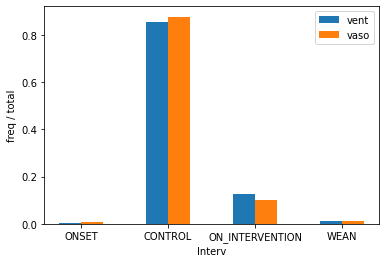

In [48]:
def cal_interv_freq(vent_label, vaso_label):
    
    num_classes = 4
    np_vent_label = np.eye(num_classes)[vent_label]
    np_vaso_label = np.eye(num_classes)[vaso_label]

    total = len(vent_label)
    freq_vent = np.sum(np_vent_label,axis=0)
    freq_vaso = np.sum(np_vaso_label,axis=0)

    x = np.arange(4)
    width = 0.25
    plt.bar(x - width/2, freq_vent / total, width, label='vent')
    plt.bar(x + width/2, freq_vaso / total, width, label='vaso')
    #plt.bar_label(x + width/2, freq_vaso / total, width, label='vaso', label_type='edge')

    plt.xticks(x, labels=['ONSET','CONTROL','ON_INTERVENTION','WEAN'])
    plt.legend()

    #plt.title('2 datasets')
    plt.xlabel("Interv")
    plt.ylabel("freq / total")
    plt.show()


cal_interv_freq(vent_labels, vaso_labels)

### Next Timepoint Will be Measured (WBM)

Predict which labs & vitals will be measured in the next hour via multi-label binary classification.


In [49]:
def create_wbm(data, adm_ids, sample_rate=1.0, observ_win=4.0, eps=1e-6, future_time_interval=1.0, start=0, end=10000, need_sample=-1):
    adm_icu_id = []
    wbm_data = []
    wbm_label = []

    # go through icu stays
    for i in trange(start, end):
        if need_sample != -1 and len(wbm_data) > need_sample:
            break

        adm_data = data[i] # (23 * T_feature)
        if adm_ids[i] not in icu_dict:
            continue
        for icustay_id in icu_dict[adm_ids[i]]:
            icu_data = []


            if pd.isnull(los_dict[str(adm_ids[i])+'_'+str(icustay_id)]):
                continue

            los = 24.0 * los_dict[str(adm_ids[i])+'_'+str(icustay_id)]  # in hours

            deathtime = adm2deathtime_dict[adm_ids[i]]
            intime = icu_dict[adm_ids[i]][icustay_id][0]
            outtime = icu_dict[adm_ids[i]][icustay_id][1]

            if deathtime is None:
                lived_time = (outtime - intime).total_seconds() / 3600.0
            else:
                lived_time = (deathtime - intime).total_seconds() / 3600.0

            # select data within icu stay
            for k in range(len(adm_data)):
                kth_feature = []
                for t, value in adm_data[k]:
                    if intime < t < outtime:

                        kth_feature.append((t, value))

                icu_data.append(kth_feature)


            sample_times = np.arange(0.0, min(los, lived_time) + eps, sample_rate) 

            # start point of observation
            sample_times = list(filter(lambda x: x < (min(los, lived_time) - observ_win), sample_times))


            for t in sample_times:
                sample_data = []
                vital_label = [0]*12
                # get data
                for feature in range(len(icu_data)):
                    f = []
                    for ft,val in icu_data[feature]:
                        if t <= (ft - intime).total_seconds() / 3600.0 < t + observ_win:
                            f.append((ft, val))
                        
                        if feature < 12 and (t + observ_win) <= (ft - intime).total_seconds() / 3600.0 < (t + observ_win + future_time_interval):
                            vital_label[feature] = 1

                    sample_data.append(f)

                adm_icu_id.append((adm2subj_dict[adm_ids[i]], adm_ids[i], icustay_id))
                wbm_data.append(sample_data)
                wbm_label.append(vital_label) 

    print("Number of created samples:", len(wbm_data), len(adm_icu_id), len(wbm_label))
    print("Number of features:", len(wbm_data[0]))
    return adm_icu_id, wbm_data, wbm_label

wbm_adm_icu_id, wbm_data, wbm_label = create_wbm(vitals, adm_id_needed, sample_rate=12.0, observ_win=48.0, eps=1e-6, future_time_interval=1.0, start=0, end=len(adm_id_needed), need_sample=-1)


100%|██████████| 1817/1817 [01:16<00:00, 23.63it/s]

Number of created samples: 18382 18382 18382
Number of features: 23


#### Statistics

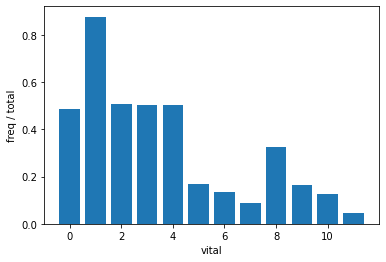

In [50]:
def cal_vital_freq(vital_label):
    np_vital_label = np.array(vital_label)
    total = len(vital_label)
    freq = np.sum(np_vital_label,axis=0)

    x = np.arange(12)
    plt.bar(x, freq/total) 
    plt.xlabel("vital")
    plt.ylabel("freq / total")
    plt.show()

cal_vital_freq(wbm_label)

### Decompensation

In [52]:
# decompensation
import sys
def create_decompensation(data, adm_ids, label, sample_rate=1.0, shortest_length=4.0, eps=1e-6, future_time_interval=24.0, start=0, end=10000, need_sample=-1):
    adm_icu_id = []
    decom_data = []
    decom_label = []

    for i in trange(start, end):
        if need_sample != -1 and len(decom_data) > need_sample:
            break

        mortality = label[i]

        # filter
        if mortality < 1:
            continue

        adm_data = data[i] # (23 * T_feature)
        if adm_ids[i] not in icu_dict:
            continue
        for icustay_id in icu_dict[adm_ids[i]]:
            icu_data = []
            # empty label
            if label[i] is None:
                continue

            if pd.isnull(los_dict[str(adm_ids[i])+'_'+str(icustay_id)]):
                #print("(length of stay is missing)", adm_ids[i], icustay_id)
                continue

            los = 24.0 * los_dict[str(adm_ids[i])+'_'+str(icustay_id)]  # in hours

            deathtime = adm2deathtime_dict[adm_ids[i]]
            intime = icu_dict[adm_ids[i]][icustay_id][0]
            outtime = icu_dict[adm_ids[i]][icustay_id][1]

            if deathtime is None:
                lived_time = 1e18
            else:
                lived_time = (deathtime - intime).total_seconds() / 3600.0

            for k in range(len(adm_data)):
                kth_feature = []
                for t, value in adm_data[k]:
                    if intime < t < outtime:
                        kth_feature.append((t, value))

                icu_data.append(kth_feature)


            sample_times = np.arange(0.0, min(los, lived_time) + eps, sample_rate) 
            sample_times = list(filter(lambda x: x > shortest_length, sample_times))

            for t in sample_times:
                sample_data = []

                # get label
                if mortality == 0:
                    cur_mortality = 0
                else:
                    cur_mortality = int(lived_time - t < future_time_interval)

                # get data
                for feature in range(len(icu_data)):
                    f = []
                    for ft,val in icu_data[feature]:
                        if t <= (ft - intime).total_seconds() / 3600.0 < t + shortest_length:
                            f.append((ft, val))

                    sample_data.append(f)

                adm_icu_id.append((adm2subj_dict[adm_ids[i]], adm_ids[i], icustay_id))
                decom_data.append(sample_data)
                decom_label.append(cur_mortality) 

    print("Number of created samples:", len(decom_data), len(adm_icu_id), len(decom_label))
    print("Number of features:", len(decom_data[0]))
    return adm_icu_id, decom_data, decom_label
  
# all
decom_adm_icu_id, decom_data, decom_label = create_decompensation(vitals, adm_id_needed, label, sample_rate=6.0, shortest_length=12.0, future_time_interval=24.0, start=0, end=len(adm_id_needed), need_sample=-1)


100%|██████████| 1817/1817 [00:15<00:00, 119.36it/s]

Number of created samples: 6267 6267 6267
Number of features: 23


In [ ]:
# calculate mortality
print(sum(decom_label))
print(len(decom_label))
sum(decom_label) / len(decom_label)

### Length of Stay Prediction

In [55]:
def number2cls(number):
        
    if number <= 7.0:
        if number <= 0:
            number = 1
        return math.ceil(number)
    elif 7 < number < 14:
        return 8
    else:
        return 9

def create_los(data, adm_ids, label, sample_rate=1.0, shortest_length=4.0, eps=1e-6, start=0, end=10000, need_sample=-1):
    adm_icu_id = []
    decom_data = []
    decom_label = []

    for i in trange(start, end):
        if need_sample != -1 and len(decom_data) > need_sample:
            break

        adm_data = data[i] # (23 * T_feature)
        if adm_ids[i] not in icu_dict:
            continue
        for icustay_id in icu_dict[adm_ids[i]]:
            icu_data = []
            # empty label
            if label[i] is None:
                continue

            if pd.isnull(los_dict[str(adm_ids[i])+'_'+str(icustay_id)]):
                #print("(length of stay is missing)", adm_ids[i], icustay_id)
                continue

            los = 24.0 * los_dict[str(adm_ids[i])+'_'+str(icustay_id)]  # in hours


            intime = icu_dict[adm_ids[i]][icustay_id][0]
            outtime = icu_dict[adm_ids[i]][icustay_id][1]

            for k in range(len(adm_data)):
                kth_feature = []
                for t, value in adm_data[k]:
                    if intime < t < outtime:
                        kth_feature.append((t, value))

                icu_data.append(kth_feature)


            sample_times = np.arange(0.0, los + eps, sample_rate) 

            sample_times = list(filter(lambda x: x > shortest_length, sample_times))

            for t in sample_times:
                sample_data = []

                # get data
                for feature in range(len(icu_data)):
                    f = []
                    for ft,val in icu_data[feature]:
                        if t <= ((ft - intime).total_seconds() / 3600.0) < t + shortest_length:
                            f.append((ft, val))

                    sample_data.append(f)

                cur_label = number2cls((los - t)/24)

                adm_icu_id.append((adm2subj_dict[adm_ids[i]], adm_ids[i], icustay_id))
                decom_data.append(sample_data)
                decom_label.append(cur_label) 

    print("Number of created samples:", len(decom_data), len(adm_icu_id), len(decom_label))
    print("Number of features:", len(decom_data[0]))
    return adm_icu_id, decom_data, decom_label


los_adm_icu_id, los_data, los_label = create_los(vitals, adm_id_needed, label, sample_rate=12, shortest_length=24, eps=1e-6, start=0, end=len(adm_id_needed), need_sample=-1)


100%|██████████| 1817/1817 [00:39<00:00, 45.55it/s]


Number of created samples: 19761 19761 19761
Number of features: 23


#### Statistics

{1: 2529, 2: 1879, 3: 1423, 4: 1134, 5: 964, 6: 811, 7: 699, 8: 3294, 9: 7028}
{1: 0.12797935327159557, 2: 0.09508628105865088, 3: 0.07201052578310814, 4: 0.057385759829968117, 5: 0.04878295632812105, 6: 0.04104043317645868, 7: 0.0353727038105359, 8: 0.1666919690299074, 9: 0.3556500177116543}


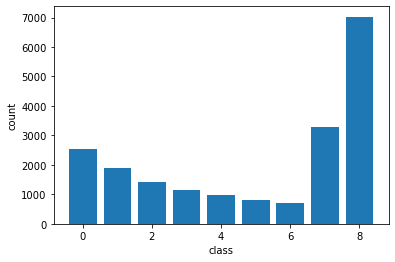

In [58]:
def statistics_los(los_label):
    countDict = dict()
    proportitionDict = dict()

    for i in set(los_label):
        countDict[i] = los_label.count(i)
        proportitionDict[i] = los_label.count(i)/len(los_label)
    
    print(countDict)
    print(proportitionDict)

    count_list = [0]*9
    for i in countDict:
        count_list[i-1] = countDict[i]

    x = np.arange(9)
    plt.bar(x, count_list) 
    plt.xlabel("class")
    plt.ylabel("count")
    plt.show()



statistics_los(los_label)


## Build Time set

In [ ]:
def trim_los(data, shortest_length=48):

    num_features = 23  # final features (excluding EtCO2)
    max_length = 2881  # maximum length of time stamp(48 * 60)
    a = np.zeros((len(data), num_features, max_length))
    timestamps = []
    rawdata=[]
    rawtimestamps = []


    for i in range(len(data)):
        l = []
        # taking union of all time stamps,
        # we don't actually need this for our model
        for j in range(num_features):
            for k in range(len(data[i][j])):
                l.append(data[i][j][k][0])

        # keeping only unique elements
        TS = []
        for j in l:
            if j not in TS:
                TS.append(j)
        TS.sort()

        temp = []
        for t in TS:
            if (t - TS[0]).total_seconds() / 3600 <= shortest_length:
                temp.append(t)

        # extracting first 48hr data
        T = copy.deepcopy(TS)
        TS = []
        for t in T:
            if (t - T[0]).total_seconds() / 3600 <= shortest_length:
                TS.append(t)
        T = []
        timestamps.append(TS)
        rawdata.append(data[i])
        rawtimestamps.append(temp)

        for j in range(num_features):
            c = 0
            for k in range(len(TS)):
                if c < len(data[i][j]) and TS[k] == data[i][j][c][0]:
                    if data[i][j][c][1] is None:
                        a[i, j, k] = -100  # missing data
                    elif (data[i][j][c][1] == 'Normal <3 secs' or
                          data[i][j][c][1] == 'Normal <3 Seconds' or
                          data[i][j][c][1] == 'Brisk'):
                        a[i, j, k] = 1
                    elif (data[i][j][c][1] == 'Abnormal >3 secs' or
                          data[i][j][c][1] == 'Abnormal >3 Seconds' or
                          data[i][j][c][1] == 'Delayed'):
                        a[i, j, k] = 2
                    elif (data[i][j][c][1] == 'Other/Remarks' or
                          data[i][j][c][1] == 'Comment'):
                        a[i, j, k] = -100  # missing data
                    else:
                        if (j == 21 or j == 22):
                            a[i, j, k] = 1
                        else:
                            a[i, j, k] = data[i][j][c][1]

                    c += 1
                else:
                    a[i, j, k] = -100  # missing data

    print("feature extraction success")
    print("value processing success ")
    return a, timestamps,rawdata, rawtimestamps

## fix time format & generate mask

In [ ]:
def fix_input_format(x, T):
    """Return the input in the proper format
    x: observed values
    M: masking, 0 indicates missing values
    delta: time points of observation
    """
    timestamp = 200
    num_features = 23

    # trim time stamps higher than 200
    for i in range(len(T)):
        if len(T[i]) > timestamp:
            T[i] = T[i][:timestamp]

    x = x[:, :, :timestamp]
    M = np.zeros_like(x)
    delta = np.zeros_like(x)
    print(x.shape, len(T))

    for t in T:
        for i in range(1, len(t)):
            t[i] = (t[i] - t[0]).total_seconds()/3600.0
        if len(t) != 0:
            t[0] = 0

    # count outliers and negative values as missing values
    # M = 0 indicates missing value
    # M = 1 indicates observed value
    # now since we have mask variable, we don't need -100

    M[x > 500] = 0
    x[x > 500] = 0.0
    M[x < 0] = 0
    x[x < 0] = 0.0
    M[x > 0] = 1

    for i in range(num_features):
        for j in range(x.shape[0]):
            for k in range(len(T[j])):
                delta[j, i, k] = T[j][k]


    return x, M, delta

## Save

In [24]:
def save_xy(in_x,in_m,in_T, label, save_path):
    
    x = np.concatenate((in_x,in_m,in_T) , axis=1)  # input format
    y = np.array(label)
    np.save(save_path + 'input.npy', x)
    np.save(save_path + 'output.npy', y)
    print(x.shape)
    print(y.shape)

    print(save_path, " saved success")

def preproc_xy(adm_icu_id, data_x, data_y, shortest_length, dataset_name):

    out_value, out_timestamps, out_rawdata, out_rawtimestamps = trim_los(data_x, shortest_length)

    x, m, T = fix_input_format(out_value, out_timestamps)
    print("timestamps format processing success")
    print("mask success")

    pickle.dump(adm_icu_id, open(dataset_name + 'sub_adm_icu_idx.p', 'wb'))
    save_xy(x, m, T, data_y, dataset_name)

In [18]:
def save_interv_xy(in_x,in_m,in_T, vent_label, vaso_label, save_path):
    
    x = np.concatenate((in_x,in_m,in_T) , axis=1)  # input format
    vent_label = np.array(vent_label)
    vaso_label = np.array(vaso_label)
    np.save(save_path + 'input.npy', x)
    np.save(save_path + 'vent_output.npy', vent_label)
    np.save(save_path + 'vaso_output.npy', vaso_label)
    print(x.shape)
    print(vent_label.shape)
    print(vaso_label.shape)

    print(save_path, " saved success")

def preproc_interv_xy(adm_icu_id, data_x, vent_label, vaso_label, shortest_length, dataset_name):

    out_value, out_timestamps, out_rawdata, out_rawtimestamps = trim_los(data_x, shortest_length)

    x, m, T = fix_input_format(out_value, out_timestamps)
    print("timestamps format processing success")
    print("mask success")

    pickle.dump(adm_icu_id, open(dataset_name + 'sub_adm_icu_idx.p', 'wb'))
    save_interv_xy(x, m, T, vent_label, vaso_label, dataset_name)


In [ ]:
# In-Hospital Mortality
preproc_xy(mor_adm_icu_id, mor_data, mor_label, 48, 'in_hospital_mortality/')

# # Decompensation
# preproc_xy(decom_adm_icu_id, decom_data, decom_label, 12, 'decom/')
#
# # Length of Stay
# preproc_xy(los_adm_icu_id, los_data, los_label, 48, 'los/')
#
# # Next Timepoint Will be Measured
# preproc_xy(wbm_adm_icu_id, wbm_data, wbm_label, 48, 'wbm/')
#
# # Clinical Intervention Prediction
# preproc_interv_xy(cip_adm_icu_id, cip_data, vent_labels, vaso_labels, 48, 'cip/')